In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import torch
import torch.nn as nn
import pandas as pd
import os
from tqdm import tqdm
from helpers import *

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


In [2]:
path = os.path.normpath(os.getcwd() + os.sep + os.pardir)

In [3]:
# Defining the cGAN model 

z_dim = 32
hidden_dim = 128
label_dim = 3

class generator(nn.Module):
    def __init__(self,z_dim = z_dim, label_dim=label_dim,hidden_dim =hidden_dim):
        super(generator,self).__init__()
        self.net = nn.Sequential(
                    nn.Linear(z_dim+label_dim, hidden_dim),
                    # nn.BatchNorm1d(hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, 24))
        
    def forward(self, input, label_onehot):
        x = torch.cat([input, label_onehot], 1)
        return self.net(x)
    
class discriminator(nn.Module):
    def __init__(self,z_dim = z_dim, label_dim=label_dim, hidden_dim =hidden_dim):
        super(discriminator,self).__init__()
        self.net =  nn.Sequential(
                    nn.Linear(24+label_dim, hidden_dim),
                    # nn.BatchNorm1d(hidden_dim),
                    nn.ReLU(),
                    nn.Linear(hidden_dim, 1),
                    nn.Sigmoid())
        
    def forward(self, input, label_onehot):
        x = torch.cat([input, label_onehot], 1)
        return self.net(x)

In [4]:
# df = pd.read_csv(os.path.join(path, 'Data', 'Flexibility', 'Summer Full.csv'))
df = pd.read_csv(os.path.join(path, 'Data', 'Flexibility', 'Winter Full.csv'))

In [5]:
# We want to train 4 different GAN models - Summer active, Summer inactive, Winter active, and Winter inactive
# arr is the label for us to separate the user groups into active/inactive

arr = [[2, 2, 0], [2, 2, 1], [2, 2, 2], [2, 1, 0], [2, 1, 1], [2, 1, 2],
       [1, 2, 0], [1, 2, 1], [1, 2, 2], [1, 1, 0], [1, 1, 1], [1, 1, 2]]

active_users = pd.DataFrame()
for label in arr:
    for i in df.columns:
        temp = df[i].copy()
        if sum(temp.iloc[-3:] == label) == 3:
            active_users = pd.concat([active_users, temp], axis=1)
        
inactive_users = pd.DataFrame()
for i in df.columns:
    temp = df[i].copy()
    if temp.iloc[-3] == 0:
        inactive_users = pd.concat([inactive_users, temp], axis=1)

In [6]:
# Selecting active users to train or inactive users

# df = active_users.copy()
df = inactive_users.iloc[:, :500].copy()

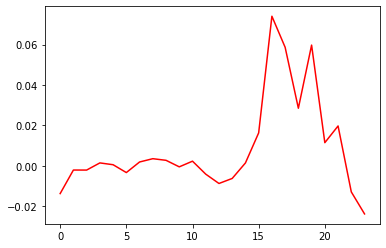

In [7]:
# plt.plot(df, c='red', lw=0.1, alpha=0.1)
plt.plot(df.iloc[:-3, :].mean(axis=1), c='red')

In [7]:
# Spliting into the flexibility profile and the labels

X, Y, x_max, x_min = get_x_and_y(df, norm=False, standard=False)

In [8]:
# Parameters for the cGAN model and initializing the generator and discriminator

net_CG = generator().to(device)
net_CD = discriminator().to(device)

batch_size = 2
lr = 1e-4
nb_epochs = 10000

optimizer_CG = torch.optim.Adam(net_CG.parameters(),lr=lr)
optimizer_CD = torch.optim.Adam(net_CD.parameters(),lr=lr)
loss_D_epoch = []
loss_G_epoch = []

In [9]:
# Creating a folder to store the trained model and keep track of the training losses

model_num = 8

os.makedirs(os.path.join(path, 'Code', 'Trained Models', 'checkpoints', f'model {model_num}'))
data = pd.DataFrame(data={'epoch': 0, 'd loss': 0, 'g loss': 0}, index=[0])
data.to_csv(os.path.join(path, 'Code', 'Trained Models', 'checkpoints', f'model {model_num}', f'loss.csv'), index=False)

In [10]:
# Training loop
# for e in tqdm(range(nb_epochs, 15000)):
for e in tqdm(range(nb_epochs)):
    rperm = np.random.permutation(X.shape[0]);
    np.take(X,rperm,axis=0,out=X);
    np.take(Y,rperm,axis=0,out=Y);
    real_samples = torch.from_numpy(X).type(torch.FloatTensor)
    real_labels = torch.from_numpy(Y).type(torch.LongTensor)
    loss_G = 0
    loss_D = 0
    for real_batch, real_batch_label in zip(real_samples.split(batch_size), real_labels.split(batch_size)):
        
        # improving D
        z = torch.empty(batch_size, z_dim).normal_().to(device)
        label_onehot = torch.FloatTensor(real_batch_label.shape[0], label_dim).zero_()
        label_onehot = label_onehot.scatter_(1, real_batch_label, 1).to(device)
        
        fake_batch = net_CG(z, label_onehot)
        D_scores_on_real = net_CD(real_batch.to(device), label_onehot)
        D_scores_on_fake = net_CD(fake_batch, label_onehot)
        
        d_loss = -torch.mean(torch.log(1-D_scores_on_fake) + torch.log(D_scores_on_real))
        optimizer_CD.zero_grad()
        d_loss.backward()

        optimizer_CD.step()
        loss_D += d_loss
        
        # improving G
        z = torch.empty(batch_size,z_dim).normal_().to(device)
        fake_batch = net_CG(z, label_onehot)
        D_scores_on_fake = net_CD(fake_batch, label_onehot)
        
        g_loss = -torch.mean(torch.log(D_scores_on_fake))
        optimizer_CG.zero_grad()
        g_loss.backward()
        optimizer_CG.step()
        loss_G += g_loss
    
    if e % 100 == 0:
        data = pd.DataFrame(data={'epoch': e, 'd loss': d_loss.cpu().detach().numpy(), 'g loss': g_loss.cpu().detach().numpy()}, index=[0])        
        loss_summary = pd.read_csv(os.path.join(path, 'Code', 'Trained Models', 'checkpoints', f'model {model_num}', f'loss.csv'))
        loss_summary = pd.concat((loss_summary, data))        
        loss_summary.to_csv(os.path.join(path, 'Code', 'Trained Models', 'checkpoints', f'model {model_num}', f'loss.csv'), index=False)
    
    if e % 1000 == 0:
        torch.save({
            'epoch': e,
            'd_state_dict': net_CD.state_dict(),
            'g_state_dict': net_CG.state_dict(),
            'd_optimizer_state_dict': optimizer_CD.state_dict(),
            'g_optimizer_state_dict': optimizer_CG.state_dict(),
            'd_loss': d_loss,
            'g_loss': g_loss
            }, os.path.join(path, 'Code', 'Trained Models', 'checkpoints', f'model {model_num}', f'model {e}.pt'))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [2:28:38<00:00,  1.27it/s]


In [9]:
# While the maximum epoch is 10000, the model might perform better at an ealier epoch, load different models here
# Summer active model = model 1; epoch 8000

checkpoint = torch.load(os.path.join(path, 'Code', 'Trained Models', 'checkpoints', 'model 1', 'model 4000.pt'))
net_CG.load_state_dict(checkpoint['g_state_dict'])

<All keys matched successfully>

In [20]:
def generate_data(generator, label, seq_num, label_dim, plot=True):
    
    label = torch.from_numpy(np.array([label])).type(torch.LongTensor)
    label_onehot = torch.FloatTensor(1, label_dim).zero_()
    label_onehot = label_onehot.scatter_(1, label, 1).to(device)
    
    df_generated = pd.DataFrame()
    j=0
    for i in range(seq_num):
        z = torch.empty(1, z_dim).normal_().to(device)
        fake_samples = generator(z, label_onehot)
        fake_data = fake_samples.cpu().data.numpy()
        df_generated.insert(0, j, pd.DataFrame(fake_data.T))
        j+=1
    
    if plot:
        plt.plot(df_generated, c='red', lw=0.1, alpha=0.1)
        plt.plot(df_generated.mean(axis=1), c='red')
        plt.title(f'Generated Flexibility Profile - {label}')
        plt.xlabel('Time (hours)')
        plt.ylabel('Flexibility - Normalized')
        plt.show()
        plt.close('all')
    
    return df_generated

In [ ]:
# This is how to save the final generators

torch.save(net_CG, os.path.join(path, 'Code', 'Final Generators', 'Summer Active Group Generator'))

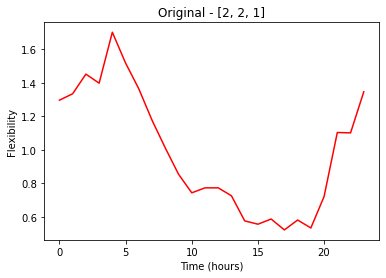

C:\Users\sienna\AppData\Local\Temp\ipykernel_1844\2918196700.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_generated.insert(0, j, pd.DataFrame(fake_data.T))
C:\Users\sienna\AppData\Local\Temp\ipykernel_1844\2918196700.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_generated.insert(0, j, pd.DataFrame(fake_data.T))
C:\Users\sienna\AppData\Local\Temp\ipykernel_1844\2918196700.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

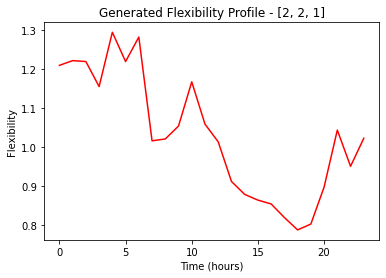

IndexError: single positional indexer is out-of-bounds

In [21]:
seq_num = 288
    
labels = [[2, 2, 1], [2, 2, 2], [1, 2, 0], [1, 2, 1], [1, 2, 2]]
    
for i in labels:

    plot_flex_label(df, Y, i, plot_profile=True, plot_ratio=False)
    generated = generate_data(net_CG, i, seq_num, label_dim, plot=False)

    generated = pd.DataFrame(generated)

    plt.plot(generated.mean(axis=1), c='red')
    plt.title(f'Generated Flexibility Profile - {i}')
    plt.xlabel('Time (hours)')
    plt.ylabel('Flexibility')
    plt.show()